# Poisson Processes

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/i9t1fq/q_poisson_process_vs_poisson_distribution/).

> I am hoping someone can give me a layman's explanation of the difference between the Poisson Process and the Poisson Distribution. I've read a couple different articles across Wikipedia, StackExchange, Statisticshowto, etc, but it's not quite sinking in.
>
> As best I understand it (in layman), the Poisson Process is a sampling of "success" data points over a period of time (eg, the number of ships that dock at a port in a given hour), and the Poisson Distribution is one of a few distribution functions whose shape may or may not represent the data collected from the process. Would this be correct to say?

This is a good question, and OP did a pretty good job answering it.
Continuing their example, suppose you are a ship spotter -- that is, someone whose hobby is to observe and identify ships.
You might be interested in the number of ships that arrive during an interval in time, or the time between arrivals, or other related questions.

A Poisson process is a model used to describe situations like this.
In the model, an event like the arrival of a ship is considered an instantaneous point in time, and it's considered to be random, with some probability of occurring during any instant.
In the simplest version of a Poisson process, that probability is considered constant, so it doesn't depend on time, the number of previous events, or the time since previous events.

Under that assumption, the number of events that happen in an interval of time follows a Poisson distribution, and the time between events follows an exponential distribution.

Of course, the real world is more complicated than that.
Ships might be more likely to arrive during the day, or at certain times of day.
There might be a minimum time between arrivals, to avoid traffic.
Or there might be a maximum capacity at the harbor, limiting the number of arrivals.

But the Poisson process can be a useful model even if its assumptions are not strictly true.
To demonstrate, let's consider another system that involves events that occur over time, goal-scoring in hockey.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/poisson_process.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py');

'utils.py'

In [3]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

From HockeyReference, I downloaded results of every game of the National Hockey League (NHL) 2023-2024 regular season (not including the playoffs).
I extracted information about goals scored during 60 minutes of regulation play, not including overtime or tie-breaking shootouts.
The results are in an HDF file with one key for each game, and a list of times, in seconds since the beginning of the game, when a goal was scored.

Raw data downloaded from <https://www.hockey-reference.com/leagues/NHL_2024_games.html> on July 16, 2024.

In [7]:
download("https://github.com/AllenDowney/DataQnA/raw/main/data/nhl_2023_2024.hdf");

Downloaded nhl_2023_2024.hdf


'nhl_2023_2024.hdf'

In [8]:
filename = "nhl_2023_2024.hdf"

with pd.HDFStore(filename, "r") as store:
    keys = store.keys()
len(keys)

1312

In [9]:
all_times = pd.concat([pd.read_hdf(filename, key=key) for key in keys])

/tmp/ipykernel_1131679/1491032017.py:1: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_times = pd.concat([pd.read_hdf(filename, key=key) for key in keys])


In [10]:
from empiricaldist import Pmf

pmf_minutes = Pmf.from_seq(all_times // 60 + 0.5)

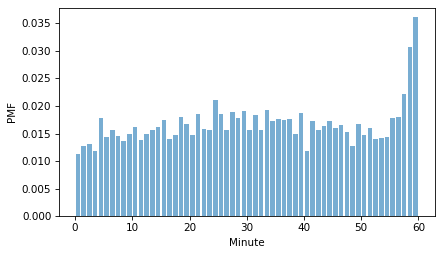

In [11]:
pmf_minutes.bar(alpha=0.6)
decorate(xlabel="Minute", ylabel="PMF")

In [30]:
goals = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    n = len(times)
    goals.append(n)

In [32]:

lam = np.mean(goals)
lam

6.0182926829268295

In [35]:
from scipy.stats import poisson

ks = np.arange(20)
ps = poisson.cdf(ks, lam)
cdf_poisson = Cdf(ps, ks, name="Poisson model")

In [36]:
cdf_goals = Cdf.from_seq(goals, name="home goals")

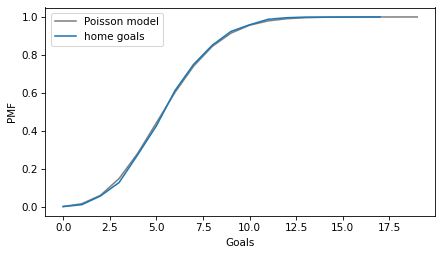

In [38]:
cdf_poisson.plot(color='gray')
cdf_goals.plot()

decorate(xlabel="Goals", ylabel="PMF")

In [90]:
firsts = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    if len(times) > 0:
        firsts.append(times[0])
    else:
        firsts.append(np.nan)
        
firsts = np.array(firsts) / 60


In [91]:
cdf_firsts = Cdf.from_seq(firsts, name="first goal", dropna=False)

In [96]:
lam = 1 / np.nanmean(firsts)
lam

0.09072940480632495

In [97]:
from scipy.stats import expon

ts = np.linspace(0, 60, 201)
ps = expon.cdf(ts, scale=1/lam)

In [98]:
from empiricaldist import Cdf

cdf_model_firsts = Cdf(ps, ts, name="exponential model")

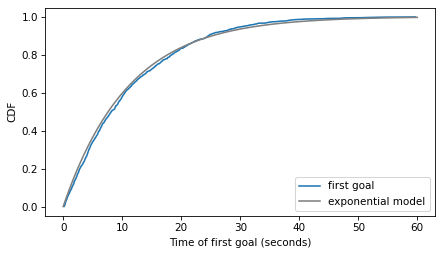

In [99]:
cdf_firsts.plot()
cdf_model_firsts.plot(color='gray')

decorate(xlabel="Time of first goal (seconds)", ylabel="CDF")

In [100]:
intervals = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    if len(times) > 1:
        intervals.extend(times.diff().dropna())
        
intervals = np.array(intervals) / 60

In [101]:
cdf_intervals = Cdf.from_seq(intervals, name="intervals")

In [102]:
lam = 1 / np.mean(intervals)
lam

0.12245019361147204

In [103]:
ps = expon.cdf(ts, scale=1/lam)
cdf_model_intervals = Cdf(ps, ts, name="exponential model")

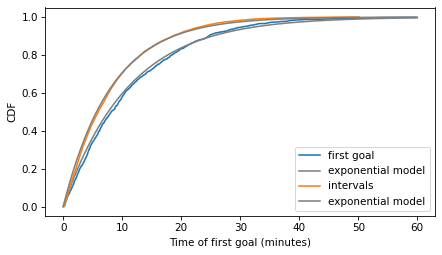

In [105]:
cdf_firsts.plot()
cdf_model_firsts.plot(color='gray')

cdf_intervals.plot(color='C1')
cdf_model_intervals.plot(color='gray')

decorate(xlabel="Time of first goal (minutes)", ylabel="CDF")

## Discussion

Poisson processes are a common source of confusion.
One reason is the word "process", which doesn't mean much in this context.
I think "model" might be clearer -- a stochastic process is a model that involves randomness in some way.

Another reason for confusion is that it is hard to define a Poisson process in its most general form.
In the examples we've considered, events happen over time, but they could also happen over space, or any other continuous domain.


[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)